## Starting Point

A pricing model we want to replicate with a neural network.

## Motivation

The belief that the neural network will cost less compute to train and predict prices (RFQs) faster than the full model. The use case will target complex path dependant (montecarlo) models that have a high compute cost and are relativly slow.

In [99]:
#
# Some set-up for the NN environment, for this we are using TensorFlow and Keras.
#
import tensorflow as tf
import numpy as np
import random
import inspect
from enum import Enum
from typing import Tuple, List, Union, Callable
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from itertools import permutations
import pandas as pd

In [2]:
#
# This is so we can visualise results
#
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Simple Model

For the purpose of experimenting with the process we define a simple Black Scholes option model. This will allow us to show the work flow and highlight the challenges with the approach.

The specific model implementation below is arbitrary, it is just a means to show how the neural network can learn a function of the same order of magnitude of complexity as a simple option contract.

In [3]:
def black_scholes_model(S: float,
                        K: float,
                        T: float,
                        r: float,
                        v: float,
                        o='c') -> float:
    """
    Implementation of Black Scholes model.

    Trivial example to demo of proof of concept for fitting an option pricing model
    with a neural network.

    :param S: Spot
    :param K: Strike
    :param T: Time to maturity
    :param r: risk free rate
    :param v: underlying volatility
    :param o: type, call or put
    :return: Option Price
    """
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * T) / (v * np.sqrt(T))

    if o == 'c':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if o == 'p':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

## Pricing Scenarios

In the real use case we will collect the back history  RFQ ( (request for quote) as training data for the neural network. This presents the first challenge as to train the model we need a spread of data across all combinations of all parameters and instrument details that impact the price we are trying to predict. If we have gaps in our training data there will also be a weakness in the model when predicting prices with that specific combination of inputs.

The nature of neural networks is to give results, even an totally untrained neural network will make predictions, just erroneous ones. So we will need to review the spread of inputs we have and make sure (expert judgment) that there are sufficient examples for all of teh combinations we are likely to quote. If the markets shift significantly we can also add additional training data, but we must be aware when the model is being asked to make predictions outside of its experience.

In this example we will create training data from scratch by running scenarios by varying the input parameters and capturing the results.

In [4]:
def parameter_scenarios(vol_range: Tuple[float, float] = (0.01, 0.4),
                        mat_range: Tuple[float, float] = (1e-6, 1.0),
                        spot_range: Tuple[float, float] = (1.0, 100.0),
                        strike_range: Tuple[float, float] = (1.0, 100.0),
                        rate_range: Tuple[float, float] = (0.01, 0.25),
                        num_steps=50) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
    """
    Create scenario vectors for volatility, maturity, spot, strike and risk-free rate

    :param vol_range: The range to vary volatility over
    :param mat_range: The range to vary maturity over
    :param spot_range: The range to vary spot over
    :param strike_range: The range to vary strike over
    :param rate_range: The range to vary risk-free rate over
    :param num_steps: number of scenario steps
    :return: volatility, maturity, spot, strike and risk-free rate scenarios as list of float
    """
    vols = [vol_range[0] + (x * ((vol_range[1] - vol_range[0]) / (num_steps - 1)))
            for x in range(num_steps)]
    mats = [mat_range[0] + (x * ((mat_range[1] - mat_range[0]) / (num_steps - 1)))
            for x in range(num_steps)]
    spots = [spot_range[0] + (x * ((spot_range[1] - spot_range[0]) / (num_steps - 1)))
             for x in range(num_steps)]
    strikes = [strike_range[0] + (x * ((strike_range[1] - strike_range[0]) /
                                  (num_steps - 1))) for x in range(num_steps)]
    rates = [rate_range[0] + (x * ((rate_range[1] - rate_range[0]) / (num_steps - 1)))
             for x in range(num_steps)]
    return vols, mats, spots, strikes, rates

In [5]:
def combinations(list1: Union[List[float], float], list2: Union[List[float], float]) -> List:
    """
    Return all combinations of the given lists

    :param list1: The first list
    :param list2: The second list
    :return: List of all combinations of lists 1 and List 2
    """
    if not isinstance(list1, List):
        list1 = [list1]
    if not isinstance(list2, List):
        list2 = [list2]
    res = []
    for x in list1:
        for y in list2:
            if not isinstance(x, List):
                x = [x]
            if not isinstance(y, List):
                y = [y]
            res.append([*x, *y])
    return res

In [6]:
def generate_model_scenarios(spot: Union[List[float], float],
                             strike: Union[List[float], float],
                             mat: Union[List[float], float],
                             rate: Union[List[float], float],
                             vol: Union[List[float], float]
                             ) -> List[Tuple[float, float, float, float, float]]:
    """
    Return a set of model scenario inputs based on given parameter scenarios

    :param vol: List of volatilities or single volatility
    :param vol: List of maturities or single maturity
    :param vol: List of spots or single spot
    :param vol: List of strike or single strike
    :param vol: List of rates or single rate
    :return: List of all combinations [[s,k,t,r,v]]
    """
    return combinations(combinations(combinations(combinations(spot, strike), mat), rate), vol)

In [7]:
def two_d_scenario(spot: Union[List[float], float],
                   strike: Union[List[float], float],
                   mat: Union[List[float], float],
                   rate: Union[List[float], float],
                   vol: Union[List[float], float],
                   price_func: Callable,
                   scaler=None) -> Tuple[List[float], str, List[float], str, np.ndarray]:

    """
    Generate a scenario where two of the given parameters are scenarios

    :param spot: spot scenario or single spot
    :param strike: strike scenario or single strike
    :param maturity: maturity scenario or single maturity
    :param rate: rate scenario or single rate
    :param vol: volatility scenario or single volatility
    :param price_func: The pricing function, either black_scholes or model.predict
    :param scaler: The scaler used to normalise the model inputs
    :return: scenario List 1, scenario parameter 1 name, scenario List 2, scenario parameter 2 name, scenario prices



    """
    params = [spot, strike, mat, rate, vol]
    arg_names = [*inspect.signature(black_scholes_model).parameters.keys()]
    scenario_params = [[x[0][0], x[0][1], x[1]] for x in zip(
        enumerate(params), arg_names) if isinstance(x[0][1], List)]
    assert (len(scenario_params) ==
            2), "Only two parameters can be passed as scenario lists"
    prices = np.zeros((len(scenario_params[0][1]), len(scenario_params[1][1])))
    for i, x in enumerate(scenario_params[0][1]):
        if scaler is None: # cell by cell
            for j, y in enumerate(scenario_params[1][1]):
                params[scenario_params[0][0]] = x
                params[scenario_params[1][0]] = y
                prices[i, j] = (price_func)(*params)
        else: # row by row as it is quicker when calling model.predict
            params[scenario_params[0][0]] = x
            params[scenario_params[1][0]] = None
            param_set = np.tile(np.asarray(params),
                                (len(scenario_params[1][1]), 1))
            param_set[:, scenario_params[1][0]] = scenario_params[1][1]
            param_set = scaler.transform(param_set)
            prices[i, :] = ((price_func)(param_set.astype(np.float64))).reshape(
                1, len(scenario_params[1][1]))
        print("{:0.0f} % Complete".format(
            100 * ((i*len(scenario_params[1][1]))/prices.size)))
    print("Done")
    return scenario_params[0][1], scenario_params[0][2],  scenario_params[1][1], scenario_params[1][2], prices

### Step 1. Generate parameter scenarios

Generate a range for each model paramater type. These will be used to generate training data by calling the model for each combination of the parameters.

In a real case we would try to collect this data as a side effect of where the real model was being used and only augment the training set where we observed gaps or thin spots in the training data

In [9]:
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)

In [10]:
Y = [black_scholes_model(*params) for params in X]

In [11]:
dfy = pd.DataFrame(Y, columns=['price'])
dfx = pd.DataFrame(X, columns=['vols', 'mats', 'spots', 'strikes', 'rates'])
dfRaw = dfx.join(dfy)

In [12]:
dfRaw.to_csv('XYRaw', encoding='ascii', index=False)

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1),copy=False).fit(X)
XScaled = scaler.transform(X)
dfxs = pd.DataFrame(XScaled, columns=['vols', 'mats', 'spots', 'strikes', 'rates'])
dfScaled = dfxs.join(dfy)

In [14]:
dfScaled.to_csv('XYScaled', encoding='ascii', index=False)

### Step 3. Create a neural network that can be regression trained to predict the price.

This is where art meet science in that there are not hard and fast rules for the size, shape and architecture of a neural network that will be able to converge on a general form of teh function in a given set of data (if one exists). There are guidelines and many types of layer that fit certain patterns for image processing etc, so there is always informed experimentation at this stage.

This is a very simple model as the data set is relatively small, however even a simple data set such as this took a number of experiments to get the right balance.

In [61]:
def create_neural_net():
    """
    Create a Neural network with an architecture tuned to regression.
    """
    
    # Create a NN of 5 Dense layers, with 5 inputs (number of BS parameters) abd a single
    # output that predicts the price for the given parameters
    model = Sequential()

    model.add(Dense(32, input_shape=(5,),
                    kernel_initializer='normal', activation='tanh'))

    model.add(Dense(16,
                    kernel_initializer='normal', activation='tanh'))

    model.add(Dense(8,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(4,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(2,
                    kernel_initializer='normal', activation='tanh'))

    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    
    # Print the model architecture out
    model.summary()
    
    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    return model 

### Step 5. Shuffle the training data & split into Test & Train data sets

1. The training data is shuffled to improve training accuracy
2. Split out a third of the data as a validation set
3. Ensure all training and test data is pur numpy arrays (not always the case after using pipeline transforms)

In [111]:
class ModelType(Enum):
    NEURAL_NET = 1
    RANDOM_FOREST_REGRESSOR = 2


def fit(X: np.ndarray,
        Y: np.ndarray,
        model_type: ModelType):
    """
    Prepare the model inputs and fit the data with the given model type.
    """

    # Shuffle & scale the data

    X = XScaled
    Xs, Ys = shuffle(X, Y, random_state=42)
    X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=0.33)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    # Create a check point to save the model version with the best validation loss

    saveBest = ModelCheckpoint(filepath='best',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               mode='min')

    # Fit to the requested type

    match model_type:
        case ModelType.NEURAL_NET:
            print("Create and fit Neural Network")
            model = create_neural_net()
            history = model.fit(X_train, Y_train,
                                batch_size=256,
                                epochs=50,
                                verbose=1,
                                validation_data=(X_test, Y_test),
                                callbacks=[saveBest])
            model.load_weights('best')

        case ModelType.RANDOM_FOREST_REGRESSOR:
            print("Create and fit Random Forest Regressor")
            model = RandomForestRegressor(n_estimators=500, verbose=2)
            model.fit(X_train, Y_train)
            history = None

        case _:
            assert False, "Invalid model type specified, see model types defined by class ModelType"

    mse = mean_squared_error(model.predict(X_test), Y_test)
    print(f"Final Mean Square Error [{mse:5f}]")
    return model, history, X_train, Y_train, X_test, Y_test

### Step 6. Train the model but fitting to the given training data

In [112]:
model, history = fit(X, Y, ModelType.RANDOM_FOREST_REGRESSOR)

Create and fit Random Forest Regressor
building tree 1 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500


In [29]:
def plot_training_history(history, skip=0):
    """
    :param vols: volatilities as %
    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('Training Epoch')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Validation Loss', color='b')
    ax1.plot(history.history['loss'][skip:], color='r')
    ax2.plot(history.history['val_loss'][skip:], color='b')
    plt.show()

### Step 7. Examine the training losses and verify if model has learned a generalisation of the option function.

We expect to see the Loss (red line) drop off exponentially as the model learns (fits) the data and the error between actual and predicted reduces.

The validation loss (blue line) should also drop off as the model get better at predicting for test data (hold out) that it has not seen during training. If the loss increases, this is an indication that the model is too powerful and has just learned the training data (over fitted) rather than fitting a generalised form of the function in the training data.

In [107]:
if history is not None:
    plot_training_history(history, skip=9)

### Step 8. Generate a result set based on direct model calls.

We generate a set of prices based on direct model calls so we can plot a pricing surface and see what the function looks like. This then also acts as the target surface we expect to see when we predict and plot the prices with the model


In [108]:
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)

In [97]:
s1,s1n,s2,s2n,actual = two_d_scenario(spot=99, strike=100, mat=0.75, rate=rates,vol=vols, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=99, strike=100, mat=0.75, rate=rates,vol=vols, price_func=model.predict, scaler=scaler)

0 % Complete
5 % Complete
10 % Complete
15 % Complete
20 % Complete
25 % Complete
30 % Complete
35 % Complete
40 % Complete
45 % Complete
50 % Complete
55 % Complete
60 % Complete
65 % Complete
70 % Complete
75 % Complete
80 % Complete
85 % Complete
90 % Complete
95 % Complete
Done
0 % Complete
5 % Complete
10 % Complete
15 % Complete
20 % Complete
25 % Complete
30 % Complete
35 % Complete
40 % Complete
45 % Complete
50 % Complete
55 % Complete
60 % Complete
65 % Complete
70 % Complete
75 % Complete
80 % Complete
85 % Complete
90 % Complete
95 % Complete
Done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [109]:
s1,s1n,s2,s2n,actual = two_d_scenario(spot=99, strike=100, mat=mats, rate=0.05,vol=vols, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=99, strike=100, mat=mats, rate=0.05,vol=vols, price_func=model.predict, scaler=scaler)

0 % Complete
5 % Complete
10 % Complete
15 % Complete
20 % Complete
25 % Complete
30 % Complete
35 % Complete
40 % Complete
45 % Complete
50 % Complete
55 % Complete
60 % Complete
65 % Complete
70 % Complete
75 % Complete
80 % Complete
85 % Complete
90 % Complete
95 % Complete
Done
0 % Complete
5 % Complete
10 % Complete
15 % Complete
20 % Complete
25 % Complete
30 % Complete
35 % Complete
40 % Complete
45 % Complete
50 % Complete
55 % Complete
60 % Complete
65 % Complete
70 % Complete
75 % Complete
80 % Complete
85 % Complete
90 % Complete
95 % Complete
Done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [34]:
def plot_price_surface(xscen,
                       yscen,
                       actual,
                       predicted,
                       title,
                       xscen_lab,
                       yscen_lab):
    """
    Plot dual surface of actual vs predicted, with a contour plot of price difference as %
    """
    minz = min(np.min(actual), np.min(predicted))
    maxz = max(np.max(actual), np.max(predicted))

    X, Y = np.meshgrid(xscen, yscen)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim3d(minz, maxz)
    c1 = ax.contourf(X, Y, ((actual-predicted)/actual)*100.0,
                     levels=range(-100, 100, 1), cmap=cm.RdGy, offset=np.min(minz))
    s1 = ax.plot_surface(X, Y, actual, cmap=cm.coolwarm,
                         linewidth=0, edgecolor='none', alpha=.7)
    s2 = ax.plot_surface(X, Y, predicted, edgecolors='k',
                         linewidth=0.1, color='gray', alpha=.3)
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0 +
                       ((ax.get_position().height)*0.15), 0.02, (ax.get_position().height)*0.7])
    cb = fig.colorbar(c1, cax=cax)
    cb.ax.set_ylabel('% difference', rotation=270)
    ax.set_xlabel(xscen_lab)
    ax.set_ylabel(yscen_lab)
    ax.set_zlabel("Option Price")
    ax.set_title(title)
    plt.show()

## Actual vs Predicted

### Surface

We plot the actuals as a surface (blue-red) and then overlay the predicted as a translucent gray surface, so we can see where the two diverge. We also plot a contour of the % difference at every point.

C:\Users\parri\AppData\Local\Temp\ipykernel_37044\2585370552.py:18: RuntimeWarning: divide by zero encountered in divide
  c1 = ax.contourf(X, Y, ((actual-predicted)/actual)*100.0,


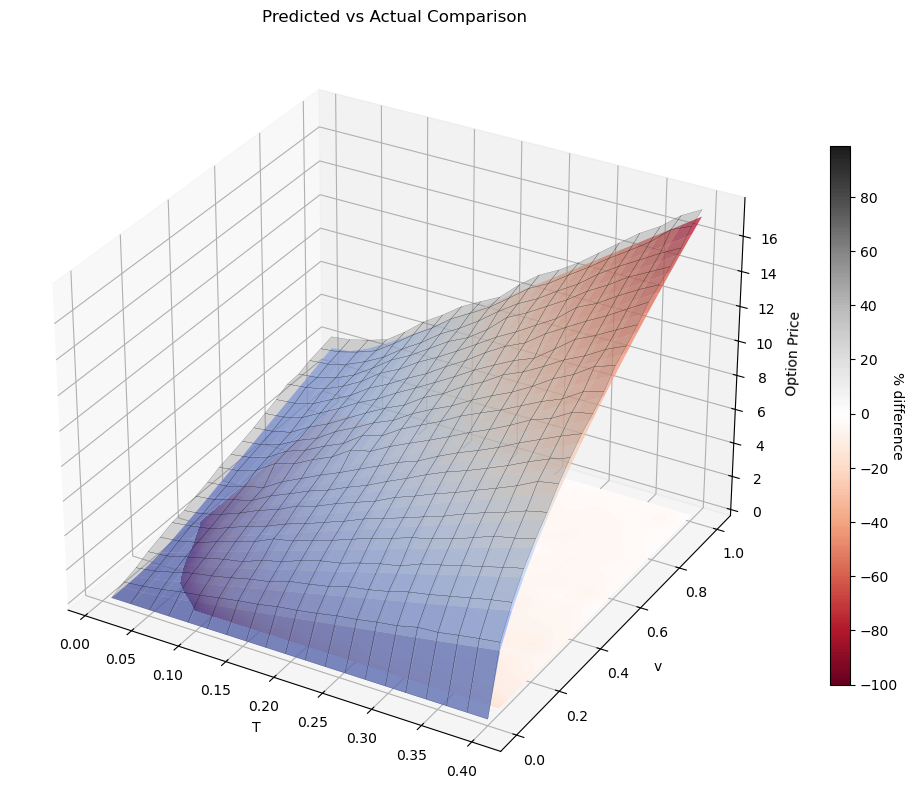

In [110]:
plot_price_surface(vols, mats, actual, predicted, title="Predicted vs Actual Comparison",
                   xscen_lab=s1n, yscen_lab=s2n)

### Scatter 
If we scatter plot actual vs predicted then we would expect to see a straight line, as for any given scenario point the actual and predicted would be equal.

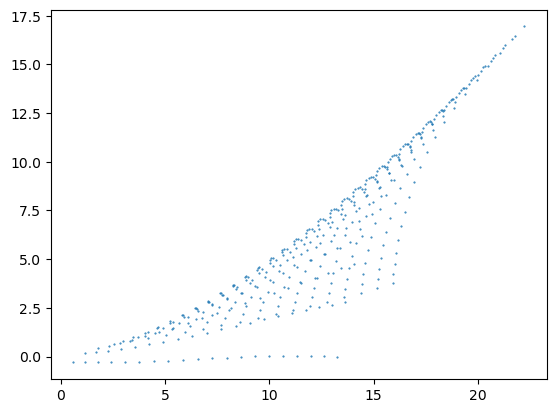

In [75]:
plt.scatter(actual.flatten(), predicted.flatten(), s=0.25)